## answers 02: the adventure of the ten Arcs
**Sean's answers**


## 1. install kallisto

`kallisto` is an example of the sort of code that I'm interested not only in using (as a program), but studying (as code), so I downloaded its source code and built my own binaries. When I install bioinformatics software from source code, I keep it in a directory of mine called `~/alien-src`. 

I work on a Mac OS/X laptop, and I prefer working on a unix command line, so my steps will reflect that.

Following the instructions at [the kallisto site](https://pachterlab.github.io/kallisto/source), first I installed some dependencies. These are examples of things that I don't currently care what's in their source code; I just want them to work, so I'm very happy to be able to install them with a good package manager. To install the dependencies, I installed [homebrew](http://brew.sh) first.

```bash
# install homebrew
% /usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
  
# install cmake
% brew install cmake
   
# install the HDF5 library
% brew install hdf5
```

Now for the kallisto code:

```bash
% wget https://github.com/pachterlab/kallisto/archive/v0.46.1.tar.gz
% tar xzf v0.46.1.tar.gz
% cd kallisto-0.46.1/
% cd ext/htslib
% autoheader
% autoconf
% cd ../..

% mkdir build
% cd build
% cmake ..
% make
% make install
```

Now I have `kallisto` in `/usr/local/bin/kallisto`. If I run it without arguments, it's supposed to give me some basic help info...

In [1]:
# Do we have kallisto installed? If we do, `kallisto` alone shows help info.
! kallisto

kallisto 0.46.1

Usage: kallisto <CMD> [arguments] ..

Where <CMD> can be one of:

    index         Builds a kallisto index 
    quant         Runs the quantification algorithm 
    bus           Generate BUS files for single-cell data 
    pseudo        Runs the pseudoalignment step 
    merge         Merges several batch runs 
    h5dump        Converts HDF5-formatted results to plaintext
    inspect       Inspects and gives information about an index
    version       Prints version information
    cite          Prints citation information

Running kallisto <CMD> without arguments prints usage information for <CMD>



## 2. Reproduce Moriarty's result

I have Moriarty's two data files [arc.fasta.gz](arc.fasta.gz) and [arc.fastq.gz](arc.fastq.gz) in my current working directory where I'm running my notebook page. 

Within the notebook page, we can run command line programs and create output files.

In the `kallisto quant` command, I have to tell `kallisto` that these are single ended data, with a fragment length distribution of mean 150, sd 20, as defined by the pset: these are the `--single -l 150 -s 20` options.

I'm sending the output into the current working directory, with `-o .`

In [2]:
# Create the kallisto index of the Arc transcriptome
! kallisto index -i arc.idx arc.fasta.gz

# Analyze the reads
! kallisto quant -i arc.idx -o . --single -l 150 -s 20 arc.fastq.gz


[build] loading fasta file arc.fasta.gz
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 19 contigs and contains 10000 k-mers 


[quant] fragment length distribution is truncated gaussian with mean = 150, sd = 20
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 26
[quant] running in single-end mode
[quant] will process file 1: arc.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 99,981 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 52 rounds



Now there's three new files in the directory. `abundance.h5` is an HDF5 file that we're not going to use. `arc.idx` is the kallisto index of the transcriptome. `abundance.tsv` is what we care about right now: the quantitation results. We still don't have to use python - we can just `cat` the file from the command line to look at it.

In [3]:
! ls -lt | head -4

total 19700
-rw-r--r-- 1 seddy staff    35848 Sep 25 08:40 abundance.h5
-rw-r--r-- 1 seddy staff      352 Sep 25 08:40 abundance.tsv
-rw-r--r-- 1 seddy staff      329 Sep 25 08:40 run_info.json


In [4]:
! cat abundance.tsv

target_id	length	eff_length	est_counts	tpm
Arc1	4000	3851	3348.79	24514.5
Arc2	2000	1851	3574.56	54440.7
Arc3	3000	2851	28065.2	277510
Arc4	4000	3851	10597.7	77579.1
Arc5	4000	3851	12526.7	91700.1
Arc6	3000	2851	1953.39	19315.2
Arc7	2000	1851	5579.78	84980.4
Arc8	2000	1851	5700.81	86823.7
Arc9	3000	2851	3052.55	30183.8
Arc10	3000	2851	25581.6	252953


Yup, those are Moriarty's results. He reported these TPM calls, rounded to two sig figs. (That Moriarty, he does know how to round off numbers properly, gotta give him that.)

So we've reproduced his result, and now we can think about why it wasn't what we expected. 

(From the perspective of the pset: this step made sure that you've got kallisto installed and you know how to run it!)

Let's pull in those numbers for later use, and we'll do it with a little function that we're reuse later.

In [5]:
def get_tpms(tsvfile):
    i = 0
    tpm = []
    with open(tsvfile) as f:
        f.readline() # skip header
        for line in f:
            tpm.append(float(line.split()[4]))
    return tpm

tpm_moriarty = get_tpms('abundance.tsv')

## 3. simulate an Arc transcriptome and RNA-seq reads

This is a small-ish example of **doing controls with synthetic data**. How much should we trust Moriarty's result with `kallisto`? With any new computational method we're trying out, it can be worthwhile to see how it performs on synthetic data where we know the answer. We know the parameters we used to generate the data, and we can see if the method can infer them.

You might say, just because the method works on synthetic data doesn't mean that it works on real data, because real data are going to be more complex. You'd be right. But the point is, if a method has problems getting the right answer on an _easy_ problem, it's not likely to do better on _harder_ ones. This is not much different than doing experimental controls, where your positive control is often an easier experiment with well-defined, well-known reagents and inputs. Just because your positive control worked, doesn't mean your experiment worked; but if your positive control failed, you should worry.

Specifically, we're going to simulate Arc read data using _our_ RNA abundance parameters. If `kallisto` infers those parameters successfully, then we still don't know where the discrepancy between our results and Moriarty's is. But if `kallisto` infers _Moriarty's_ result when we give it synthetic data that have been explicitly generated using _our_ abundance parameters, then the problem lies in `kallisto`, or in how we're using it.

I'm going to cheat a little here: I'm going to go ahead and write in code that I need for part 5 of the answer, and when I get there I'm going to rerun the notebook page with different parameter settings. A more elegant strategy would be to modularize my simulator inside a Python function that I can call with different options.

I'm going to show the more difficult (3b) path through the pset here, which includes sampling a fragment length, simulating reads in both orientations, and simulating occasional base-calling errors in the reads. I'll put comments on stuff that you would just skip over in the easier (3a) path through the pset.



In [2]:
import numpy  as np
import string
import sys

In [3]:
# Options that control how I'm going to run the simulation
do_pset       = True    # Use exactly the Arc structure and abundance params from the pset
do_no_overlap = False   # Variant with all L[i] = one segment so there's no overlap (makes inference problem trivial)
do_no_circle  = False   # Variant with no circular permutation (as we'll see, one candidate/suspected problem in kallisto)

# Names of files we're going to generate: simdata.{fasta,fastq,dat}
outpfx     = 'simdata'
fasta_file = '{}.fasta'.format(outpfx)  # transcriptome file
fastq_file = '{}.fastq'.format(outpfx)  # reads

In [4]:
# Set up the Arc locus 
#
S         = 10                     # Number of segments in the Arc locus (A..J)
T         = S                      # Number of different transcripts (the same, one starting on each segment, 1..10)
N         = 100000                 # total number of observed reads we will generate 
alpha     = 0.999                  # base calling accuracy (Q30 bases, typical of Illumina) ... unused in (3a) version
len_S     = 1000                   # length of each segment (nucleotides)
len_Arc   = len_S * S              # total length of the Arc locus (nucleotides)
len_R     = 75                     # read length
mean_frag = 150                    # fragment size: mean (of a truncated Gaussian)  ... unused in (3a) version
sd_frag   = 20                     # fragment size: stdev                           ... unused in (3a) version

Slabel  = list(string.ascii_uppercase)[:S]               # ['A'..'J']        : the upper case labels for Arc locus segments 
Tlabel  = [ "Arc{}".format(d) for d in range(1,T+1) ]    # ['Arc1'..'Arc10'] : the labels for Arc transcript isoforms


In [5]:
# Encode base accuracy, Sanger format: we only need one QV for all our data, keep that character code in <qvchar>
# kallisto ignores this information, so we could just as easily just set this to any valid QV, like '?' (Q30) or 'I' (Q40),
# which is what you'd do in version (3a) where you wouldn't be using <alpha> and introducing simulated basecall errors.
qv     = int(round(-10 * np.log10 ( 1. - alpha)))
if qv > 93: qv = 93
if qv < 0:  qv = 0
qvchar = chr(qv+33)

In [6]:
# Set up the parts of the Arc locus model that we can randomize, if we want.

# The do_pset option sets up exactly the same parameters as our params from the pset
# We can also get the same result by setting the numpy RNG seed to 20160925, 
# if you don't alter the order in which we're calling np.random.
#
if do_pset:
    nu = np.array([0.008, 0.039, 0.291, 0.112, 0.127, 0.008, 0.059, 0.060, 0.022, 0.273])
    L  = np.array([4000,  2000,  3000,  4000,  4000,  3000,  2000,  2000,  3000,  3000]).astype(int)
else:
    nu = np.random.dirichlet(np.ones(T))                       # true expression levels \nu: P(Ti | nu_i)
    L  = [ len_S * np.random.randint(2,5) for _ in range(T) ]  # each isoform i is 2..4 segments long
# (what's np.random.dirichlet() do, you ask? It's a useful trick for sampling a uniformly-distributed probability vector, using a so-called Dirichlet distribution.)


# The do_no_overlap option forces each transcript to be 1 segment long, thus nonoverlapping.     
if do_no_overlap:
    L    =  np.multiply(np.ones(T), len_S).astype(int)            
    
# The do_no_circle option truncates lengths L[i] as needed to avoid any overlap due to circular permutation
if do_no_circle:   
    for i in range(T):
        if i*1000 + L[i] > len_Arc:
            L[i] = len_Arc - i*1000    # i.e. the Arc that starts at 9 must be 1 long. 


In [7]:
# Make extra sure that the theta's sum to one. Due to roundoff error, the pset numbers don't quite!
Z  = np.sum(nu)
nu = np.divide(nu, Z)

**We generate a random Arc DNA sequence for the whole locus:**

In [8]:
# Sample the Arc locus nucleotide sequence, as a string.
#
Arc_locus = ''.join(np.random.choice(list('ACGT'), len_Arc))


**then we extract the individual Arc transcript sequences:**

We have to deal with Arc being a circle. When we go to extract an Arc transcript that rolls around the circle, we have to do something to extract it in two pieces from the linear `Arc_locus[]` list we just generated.

There's other ways to do this too!

In [13]:
# From that, extract the individual Arc1-Arc10 transcript sequences:
#
Arc = []
for i in range(T):
    start = i * len_S
    end   = (start + L[i] - 1) % len_Arc   # circularly permuted!
    if end < start:
        Arc.append( Arc_locus[start:] + Arc_locus[:end+1] )  # watch out for that circular permutation; fetch in two pieces.
    else:
        Arc.append( Arc_locus[start:end+1] )


**write the transcriptome file, in FASTA format:** 

In [14]:
# Write the Arc1-Arc10 transcriptome to a FASTA file.
#
def write_fasta(f, seqname, seq):
    print(">{}".format(seqname), file=f)
    for i in range(0, len(seq), 60):
        if i+60 > len(seq):
            line = ''.join(seq[i:])
        else:
            line = ''.join(seq[i:i+60])
        print(line, file=f)

with open(fasta_file, 'w') as f:
    for i in range(T):
        write_fasta(f, Tlabel[i], Arc[i])


that file should be there now, right?


In [15]:
! head simdata.fasta

>Arc1
CAGTACTATTGACAAAAAGGGTCAATCCGTCGTTGCAAGGCGGTCGATAGTTAAGCCTAT
TTTCTTTGCGCGTAGAAGTGTGGCTCGAAGGTTCCCATTGGGCTAACGCGCCGGGTAACA
TGGCCGTCTGCATCCTTAGGTAGCCCGGAAGGGTCTAAACCATGTCACGCGTTCCTAGGT
AGTTGGTGACTCACGCGGTAATTAGAGCTTCAGACCACTTCCTTACCAGTATCTGCCATA
TCCCCGAAATCGGCCATGAAACGCGTAACTATAGAGTTCTGTCTAGGAGAGGCGGATCAG
TCCCACGGGAACAGTCGACGATCACGGCCGCCAGGTGTGGGTGGGGGGAGACAAAAAATG
CAAGATTATATTTGTCACGATTGCTACGCTATGGATCAGACTAAGATTACAAACTTCACG
GCCACAGCCAAAAACAAATACTTAACTCTGAAACGCCTGAGCCCTGGACACTTTCCGCCT
CTCCCGGACCGCGTTTACCCATTAATACACGGGCTCGCTAGAGCCTGGAACCGATTGCGC


right.

**generate reads, and write them to their output FASTQ file as we go:**

(Takes a bit of time. Watch the `In [*]` to the left; while it's still an asterisk, it's still running the code.)

In [16]:
# Generate reads
#
with open(fastq_file, 'w') as f:
    for n in range(N):                         # for each independent read that we sample:

        i    = np.random.choice(T, p=nu)       # choice of isoform i = 0..T-1, according to nucleotide abundance nu_i       

        while True:                            # sample a random fragment length from a truncated Gaussian, >= readlength, <= L. (unused in (3a) version)
            flen = int(np.random.normal(mean_frag, sd_frag))
            if flen >= len_R: break
        if flen > L[i]: flen = L[i]            # in the simpler (3a) version you could just set flen=75 ... then remember to set your `kallisto quant` frag len 
                                               # parameters accordingly, with frag len of 75 and a small nonzero std dev, something like `-l 75 -s 5`

        j    = np.random.choice(L[i]-flen+1)   # choice of start position j = 0..L[i]-flen
        if np.random.choice(2) == 0:           # orientation: 0 = sense, 1 = antisense  ... in the simpler (3a) version you'd just sample the sense orientation.
            read = Arc[i][j:j+len_R]           # extract the read sequence 
        else:        
            read = Arc[i][j+flen-1:j+flen-len_R-1:-1]             # fetching it in reverse orientation! note the 3rd arg, -1
            read = read.translate(str.maketrans('ACGT', 'TGCA'))  # one of many ways you can complement a sequence

        # Now dirty it up: add random basecall errors, according to accuracy <alpha>
        # You'd skip this in the (3a) version.
        seq = list(read)
        for i in range(len(seq)):
            if np.random.uniform() > alpha:
                c = seq[i]
                while c == seq[i]:                      # this `while` loop uniformly samples one of 3 possible mutations,
                    c = np.random.choice(list('ACGT'))  # for any starting residue <seq[i]>
                seq[i] = c
        read = ''.join(seq)

        print("@read{}".format(n),        file=f)
        print(read, file=f)
        print("+",  file=f)
        print("{}".format(''.join(qvchar*len_R)), file=f)



we've got a read file now, right?

In [17]:
! head simdata.fastq

@read0
GCCCGCTTGTATGATCGATCACGTTCTTGGTGTTCCATCTTTGGATGACTGAACCGCGTCTTTCATGGTTAGGTA
+
???????????????????????????????????????????????????????????????????????????
@read1
GTGCTGATTTACACGCGTCCCGTTGTATTGTGTTCGCCTTAGTCTTAATGCTTCGACTCCCAGTCTATGTTAGGG
+
???????????????????????????????????????????????????????????????????????????
@read2
CTGTCCAAAGACTCGATCGGGAGTTGTGCTCTATACCATGCCGGCCATATATCACGCTCGGCGGAGAGTTATCAC


right. (The question marks look scary, but that's the QV code for a Q30 base.)

Now let's deal with a pesky detail before we output the final summary. Our $\nu_i$ are _nucleotide abundances_; to compare to the `kallisto` TPM output, we convert to per-transcript abundances in TPM. Now `tpm[]` are our known abundances in TPM, which we'll compare to `kallisto`'s inferred TPM.

In [18]:
# tpm versus theta, per-transcript vs per-nucleotide abundance
#
tpm = np.array( [ nu[i] / L[i] for i in range(T) ])
Z   = np.sum(tpm)
tpm = np.divide(tpm, Z)
tpm = np.multiply(tpm, 1000000)


**print info about the simulation, including (most importantly) the true Arc abundances:**

In [19]:
# Output information on the transcript structure and expression level
#
print("The {} transcripts of the sand mouse Arc locus:".format(T))
print("| {0:10s} | {1:5s} | {2:8s} | {3:6s} | {4} |".format("transcript", "nu", "TPM", "length", "segments_covered"))
print("| {0:10s}-|-{1:5s}-|-{2:8s}-|-{3:6s} | {4} |".format('-'*10, '-'*5, '-'*8, '-'*6, '-'*16))
for i in range(T):
    print ("| {0:10s} | {1:5.3f} | {2:8.1f} | {3:6d} | ".format(Tlabel[i], nu[i], tpm[i], L[i]), end="")
    for j in range(i,i+(L[i]//len_S)):
        print("{}".format(Slabel[j%S]), end="")
    print("")
print("")

print("alpha:                  {}".format(alpha))
print("mean fragment size:     {}".format(mean_frag))
print("fragment size std dev.: {}".format(sd_frag))
print("read length:            {}".format(len_R))
print("number of reads:        {}".format(N))
print("")

if do_no_circle:
    print("(no circle variant)")
if do_no_overlap:
    print("(no overlap variant)")


The 10 transcripts of the sand mouse Arc locus:
| transcript | nu    | TPM      | length | segments_covered |
| -----------|-------|----------|------- | ---------------- |
| Arc1       | 0.008 |   5904.1 |   4000 | ABCD
| Arc2       | 0.039 |  57564.6 |   2000 | BC
| Arc3       | 0.291 | 286346.9 |   3000 | CDE
| Arc4       | 0.112 |  82656.8 |   4000 | DEFG
| Arc5       | 0.127 |  93726.9 |   4000 | EFGH
| Arc6       | 0.008 |   7872.1 |   3000 | FGH
| Arc7       | 0.059 |  87084.9 |   2000 | GH
| Arc8       | 0.060 |  88560.9 |   2000 | HI
| Arc9       | 0.022 |  21648.2 |   3000 | IJA
| Arc10      | 0.273 | 268634.7 |   3000 | JAB

alpha:                  0.999
mean fragment size:     150
fragment size std dev.: 20
read length:            75
number of reads:        100000



## 4. test kallisto

We're ready to run `kallisto` on the simulated data.

In [20]:
# Create the kallisto index of the simulated Arc transcriptome
! kallisto index -i simdata.idx simdata.fasta

# Analyze the simulated reads
! kallisto quant -i simdata.idx -o . --single -l 150 -s 20 simdata.fastq

# Cat the output file so we can see it in our notebook page
! cat abundance.tsv

# and read in those tpms.
tpm_kallisto = get_tpms('abundance.tsv')


[build] loading fasta file simdata.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 19 contigs and contains 10000 k-mers 


[quant] fragment length distribution is truncated gaussian with mean = 150, sd = 20
[index] k-mer length: 31
[index] number of targets: 10
[index] number of k-mers: 10,000
[index] number of equivalence classes: 26
[quant] running in single-end mode
[quant] will process file 1: simdata.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 100,000 reads, 99,989 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 55 rounds

target_id	length	eff_length	est_counts	tpm
Arc1	4000	3851	3167.09	23193.2
Arc2	2000	1851	3371.18	51362.8
Arc3	3000	2851	28453.9	281461
Arc4	4000	3851	10692.4	78302.6
Arc5	4000	3851	12499.6	91537.1
Arc6	3000	2

Does that look more like the correct answer (the $\nu_i$ we used to create the positive control simulated data), or does it look more like Moriarty's result? Hey, a good reason to plot some graphs with a little matplotlib code.

<IPython.core.display.Javascript object>


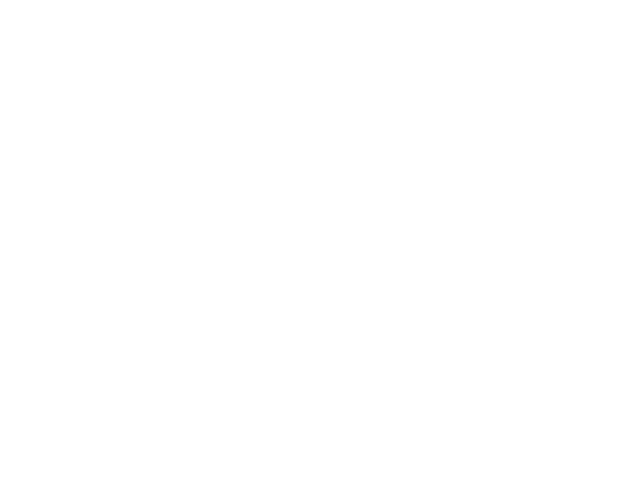

In [21]:
import matplotlib.pyplot as plt
%matplotlib notebook

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.loglog(tpm, tpm_kallisto, 'o')
expect = [1e3, 1e6]
ax1.plot(expect, expect)
ax1.set_xlabel('True TPM parameters of the simulation')
ax1.set_ylabel('kallisto inferred TPM parameters')

ax2.loglog(tpm_moriarty, tpm_kallisto, 'o')
ax2.plot(expect, expect)
ax2.set_xlabel("Moriarty's TPM parameters")
ax2.set_ylabel('kallisto inferred TPM parameters')

f.tight_layout()



**Huh.** 

kallisto is overestimating the abundances of the two least abundant Arc transcripts -- thus (possibly) accounting for Moriarty's result.

## 5. 'debug' kallisto

My first guess for what's going on was that there's something in `kallisto` that can't deal with the circular permutation of the Arc locus. There's nothing in the `kallisto` paper to suggest it should have a problem with this, and no reason I can think of why it should -- de Bruijn graphs certainly can (and often do) have directed cycles in real data, for example.

But... now I'll go back up and rerun the notebook cells but with the `do_no_circle` option on. (This is a hack - again, it'd be better if I'd define a function that runs the simulation!) Note that changing the lengths of transcripts changes their TPM, even though we haven't changed the true nucleotide abundances!

Clicky clicky clicky as I rerun the cells down to the point of reloading the abundance.tsv file, and:

Text(0, 0.5, 'kallisto inferred parameters')

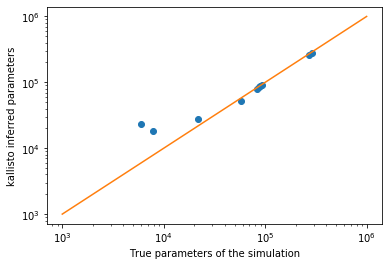

In [22]:
f, ax3 = plt.subplots()
ax3.loglog(tpm, tpm_kallisto, 'o')
ax3.plot(expect, expect)
ax3.set_xlabel('True parameters of the simulation')
ax3.set_ylabel('kallisto inferred parameters')

Interesting. Now it's getting Arc1 right. But it's still messing up on Arc6.

Another 'debugging' control we can run is a drastic one - let's remove _all_ the overlaps between Arc transcripts, and make sure that `kallisto` works in the trivial case. 

Again, hacking - go back up and set the `do_no_overlap` option, and rerun the notebook, including the graphs above. Now we see `kallisto` nail it, as it should.



## Conclusions

A little puzzling, actually! De-circularizing the Arc locus fixed Arc1 but not Arc6, so it's not solely a matter of circularization. Removing all overlaps (so all reads uniquely map) fixes the problem completely, but of course it does; it makes the problem trivial, and the whole point of kallisto is to infer transcript abundances even when transcripts overlap.

We've run this problem every year that MCB112 has been taught and it's still not clear what's going on. And new versions of kallisto continue to show the same behavior. The best solution that I've seen was contributed by Will Mallard, one of the TFs in 2017. You can [download his pset solution .ipynb file from 2017](http://mcb112.org/w02/w02-answers-WM.ipynb). Will's experiments show that for _low abundance_ transcripts, kallisto needs _at least one piece of that transcript to be unique_ (i.e. reads map uniquely to it). De-circularization, in Will's view, is a red herring; what also happens when we decircularize is that the A segment becomes unique to Arc1, and kallisto accurately quantitates Arc1. When he did simulations where he removes overlaps from the start of Arc6, kallisto accurately quantitates Arc6. 

Again, there's no reason (mathematically) why kallisto should have a problem with the overlaps, even though our Arc locus is a pretty pathological case... and it's puzzling that it only has a problem with quantitating low-abundance transcripts. But Will's dissection is the best so far.